In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import cartopy
import cmocean
import xarray as xr

from load_tuning_results import (
    load_results_raw,
    load_result_for_key,
    add_derived_features,
    filter_suspicious_routes,
    load_results,
    get_seed_routes_gdf,
    get_forcing_paths_df,
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
# parameters

# extent
lon_min, lon_max = -80 - 5, -10 + 5
lat_min, lat_max = 25 - 5, 55 + 5

# results dataframe from
gpq_file = "results/results_prelim.geoparquet"

# single results file
results_file = "results/results_19430020.msgpack"

# Configure route visualization styles

# Color mapping for journey direction (easily customizable)
ROUTE_COLORS = {
    "Atlantic_forward": "magenta",
    "Atlantic_backward": "orange",
}

# Linestyle mapping for hazard enforcement
ROUTE_LINESTYLES = {
    False: "-",  # solid = hazards enforced
    True: "--",  # dashed = hazards ignored
}

# Route visualization parameters
ROUTE_LINEWIDTH = 1.5
ROUTE_ALPHA = 1.0
SEED_COLOR = "cyan"
SEED_LINEWIDTH = 1.5
SEED_ALPHA = 1.0

In [3]:
# Create style lookup helper function
def get_route_style(journey_name, ignore_hazards):
    """Get plotting style for route configuration."""
    return {
        "color": ROUTE_COLORS[journey_name],
        "linestyle": ROUTE_LINESTYLES[ignore_hazards],
        "linewidth": ROUTE_LINEWIDTH,
        "alpha": ROUTE_ALPHA,
    }

In [4]:
print(lon_min, lon_max, lat_min, lat_max)

lon_cent = (lon_min + lon_max) / 2.0
lat_cent = (lat_min + lat_max) / 2.0
print(lon_cent, lat_cent)

-85 -5 20 60
-45.0 40.0


In [5]:
gdf = gpd.read_parquet(gpq_file)
gdf = add_derived_features(gdf)
gdf

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,geometry,hyper_num_individuals,journey_duration,seed_cost,elite_speed_og_mps_average
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T17-46-22.757_c17b2c84-f6f5-4c24-86b1-576e05ce458f,32,202838879,0.3,0.5,0.10,4,32,0,0.10,0.00,...,0,6.093342e+06,1.000000,NaN,NaN,"LINESTRING (-11 50, -12.5391 50.09982, -14.083...",128,13 days 17:00:51,inf,5.144445
result:2025-12-06T17-45-47.883_8a96049a-b448-4688-a683-7bc1ad2f08f1,32,240864382,0.3,0.9,0.10,4,32,1,0.10,0.25,...,0,6.093342e+06,1.000000,NaN,NaN,"LINESTRING (-11 50, -12.5391 50.09982, -14.083...",128,13 days 17:00:51,inf,5.144445
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,128,1282251641,0.3,0.5,0.25,1,128,2,0.25,0.00,...,0,6.102691e+06,1.001534,9.154279e+12,0.948557,"LINESTRING (-11 50, -12.53111 50.10597, -14.06...",128,13 days 17:00:51,9.650747e+12,5.152337
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,128,1282251641,0.3,0.5,0.25,1,128,2,0.25,0.00,...,1,6.096694e+06,1.000550,9.457689e+12,0.979995,"LINESTRING (-11 50, -12.52763 50.10524, -14.06...",128,13 days 17:00:51,9.650747e+12,5.147274
result:2025-12-06T16-34-19.208_1ba20d20-34f7-44e0-b86b-61d0db88fe09,32,3459840799,0.3,0.5,0.25,4,32,2,0.25,0.25,...,0,6.237164e+06,1.023603,1.018871e+13,0.000000,"LINESTRING (-80.5 30, -79.65864 30.68667, -78....",128,13 days 17:00:51,inf,5.265869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-07T20-31-58.625_46e15cd9-a913-45f7-8281-cbaa2872ee10,128,1835893064,0.3,0.5,0.25,4,128,0,0.10,0.00,...,0,6.117856e+06,1.004023,8.579450e+12,0.911326,"LINESTRING (-11 50, -12.84446 50.09778, -14.64...",512,11 days 10:10:42,9.414248e+12,6.198172
result:2025-12-07T20-31-58.625_46e15cd9-a913-45f7-8281-cbaa2872ee10,128,1835893064,0.3,0.5,0.25,4,128,0,0.10,0.00,...,1,6.117856e+06,1.004023,8.579450e+12,0.911326,"LINESTRING (-11 50, -12.84446 50.09778, -14.64...",512,11 days 10:10:42,9.414248e+12,6.198172
result:2025-12-07T20-11-44.075_c6ae1298-a99c-48fd-ad6f-ba982e260699,128,3662113073,0.3,0.9,0.10,2,128,1,0.10,0.25,...,0,6.093342e+06,1.000000,NaN,NaN,"LINESTRING (-80.5 30, -79.4778 30.80166, -78.4...",256,11 days 10:10:42,inf,6.173337


In [6]:
# Load results and extract seed routes
results = load_results([results_file])
gdf_seed = get_seed_routes_gdf(results)
gdf_seed

records:   0%|          | 0/1989 [00:00<?, ?it/s]

seed routes:   0%|          | 0/1989 [00:00<?, ?it/s]

,seed_length_meters,geometry
filename,,
result:2025-12-06T17-46-22.757_c17b2c84-f6f5-4c24-86b1-576e05ce458f,6.093342e+06,"LINESTRING (-11 50, -12.5391 50.09982, -14.083..."
result:2025-12-06T17-45-47.883_8a96049a-b448-4688-a683-7bc1ad2f08f1,6.093342e+06,"LINESTRING (-11 50, -12.5391 50.09982, -14.083..."
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,6.093342e+06,"LINESTRING (-11 50, -12.5391 50.09982, -14.083..."
result:2025-12-06T16-34-19.208_1ba20d20-34f7-44e0-b86b-61d0db88fe09,6.093342e+06,"LINESTRING (-80.5 30, -79.64622 30.67104, -78...."
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,6.093342e+06,"LINESTRING (-80.5 30, -79.64622 30.67104, -78...."
...,...,...
result:2025-12-06T16-48-34.576_37806ea0-417a-4244-b0e1-c6b87a121e31,6.093342e+06,"LINESTRING (-80.5 30, -79.64622 30.67104, -78...."
result:2025-12-06T17-34-13.902_119dc432-f4e9-4769-83f7-0a5ee0b9420d,6.093342e+06,"LINESTRING (-11 50, -12.5391 50.09982, -14.083..."
result:2025-12-06T17-07-03.019_16587069-7b34-4460-acf6-d81b11de38a7,6.093342e+06,"LINESTRING (-80.5 30, -79.64622 30.67104, -78...."


In [7]:
# map start times to month (to match with figure)
gdf["time_month"] = pd.to_datetime(gdf.journey_time_start.astype(str)).dt.strftime(
    "%Y-%m"
)

# select elites based on minimum abs cost.
best_elites_gdf = (
    gdf.groupby(["journey_name", "time_month", "hyper_ignore_hazards"], dropna=False)
    .apply(lambda g: g.loc[g.elite_cost_absolute.idxmin()])
    .reset_index(drop=True)
)

# convert back to gdf
best_elites_gdf = gpd.GeoDataFrame(best_elites_gdf, geometry="geometry")

In [8]:
best_elites_gdf

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,geometry,hyper_num_individuals,journey_duration,seed_cost,elite_speed_og_mps_average,time_month
0,128,2307102885,0.3,0.9,0.25,2,128,1,0.10,0.00,...,6.662703e+06,1.093440,6.431162e+12,0.000000,"LINESTRING (-11 50, -12.17478 50.08884, -13.36...",256,17 days 03:16:03,inf,4.500114,2021-01
1,128,2307102885,0.3,0.9,0.25,2,128,1,0.10,0.00,...,6.662703e+06,1.093440,6.431162e+12,0.000000,"LINESTRING (-11 50, -12.17478 50.08884, -13.36...",256,17 days 03:16:03,inf,4.500114,2021-01
2,128,238449395,0.3,0.9,0.10,2,128,1,0.10,0.25,...,6.126759e+06,1.005484,6.148006e+12,0.849611,"LINESTRING (-11 50, -12.19953 50.07591, -13.41...",256,17 days 03:16:03,7.236264e+12,4.138128,2021-01
3,128,238449395,0.3,0.9,0.10,2,128,1,0.10,0.25,...,6.126759e+06,1.005484,6.148006e+12,0.849611,"LINESTRING (-11 50, -12.19953 50.07591, -13.41...",256,17 days 03:16:03,7.236264e+12,4.138128,2021-01
4,128,1807470446,0.3,0.5,0.25,4,128,0,0.10,0.25,...,6.155933e+06,1.010272,4.987090e+12,0.893960,"LINESTRING (-11 50, -12.20977 50.07285, -13.44...",512,17 days 03:16:03,5.578648e+12,4.157832,2021-03
5,128,1807470446,0.3,0.5,0.25,4,128,0,0.10,0.25,...,6.155933e+06,1.010272,4.987090e+12,0.893960,"LINESTRING (-11 50, -12.20977 50.07285, -13.44...",512,17 days 03:16:03,5.578648e+12,4.157832,2021-03
6,32,675698088,0.3,0.5,0.10,4,32,2,0.10,0.00,...,6.153073e+06,1.009803,4.721456e+12,0.846344,"LINESTRING (-11 50, -12.21491 50.06991, -13.44...",128,17 days 03:16:03,5.578648e+12,4.155901,2021-03
7,32,675698088,0.3,0.5,0.10,4,32,2,0.10,0.00,...,6.153073e+06,1.009803,4.721456e+12,0.846344,"LINESTRING (-11 50, -12.21491 50.06991, -13.44...",128,17 days 03:16:03,5.578648e+12,4.155901,2021-03
8,128,3663179108,0.3,0.5,0.10,4,128,0,0.25,0.00,...,6.247616e+06,1.025318,4.173366e+12,0.879217,"LINESTRING (-11 50, -12.22918 50.08038, -13.46...",512,17 days 03:16:03,4.746683e+12,4.219757,2021-05
9,128,3663179108,0.3,0.5,0.10,4,128,0,0.25,0.00,...,6.247616e+06,1.025318,4.173366e+12,0.879217,"LINESTRING (-11 50, -12.22918 50.08038, -13.46...",512,17 days 03:16:03,4.746683e+12,4.219757,2021-05


In [9]:
# Extract forcing paths
forcing_df = get_forcing_paths_df(results)
forcing_currents_path = forcing_df["forcing_currents_path"].iloc[0]
print(forcing_currents_path)
forcing_waves_path = forcing_df["forcing_waves_path"].iloc[0]
print(forcing_waves_path)
forcing_winds_path = forcing_df["forcing_winds_path"].iloc[0]
print(forcing_winds_path)

data_large/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr
data_large/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr
data_large/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr


In [10]:
ds_currents = xr.open_zarr(forcing_currents_path)
ds_currents = ds_currents.sel(
    longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max)
)
ds_currents = ds_currents.assign(
    speed=(ds_currents.to_array() ** 2).sum("variable") ** 0.5
)
ds_currents = ds_currents.resample(time="1M").mean().compute()
ds_currents = ds_currents.where(ds_currents.speed > 0)
ds_currents

<xarray.Dataset> Size: 67MB
Dimensions:    (time: 12, latitude: 481, longitude: 961)
Coordinates:
  * time       (time) datetime64[ns] 96B 2021-01-31 2021-02-28 ... 2021-12-31
  * latitude   (latitude) float32 2kB 20.0 20.08 20.17 ... 59.83 59.92 60.0
  * longitude  (longitude) float32 4kB -85.0 -84.92 -84.83 ... -5.083 -5.0
    depth      float32 4B 0.494
Data variables:
    uo         (time, latitude, longitude) float32 22MB 0.0391 ... 0.2189
    vo         (time, latitude, longitude) float32 22MB -0.1316 ... 0.148
    speed      (time, latitude, longitude) float32 22MB 0.1658 0.1872 ... 0.2689
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

In [11]:
ds_waves = xr.open_zarr(forcing_waves_path)
ds_waves = ds_waves.sel(
    longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max)
)
ds_waves = ds_waves.resample(time="1M").quantile(0.9).compute()
ds_waves

<xarray.Dataset> Size: 15MB
Dimensions:    (time: 12, latitude: 201, longitude: 401)
Coordinates:
  * time       (time) datetime64[ns] 96B 2021-01-31 2021-02-28 ... 2021-12-31
  * latitude   (latitude) float32 804B 20.0 20.2 20.4 20.6 ... 59.6 59.8 60.0
  * longitude  (longitude) float32 2kB -85.0 -84.8 -84.6 ... -5.4 -5.2 -5.0
    quantile   float64 8B 0.9
Data variables:
    VHM0       (time, latitude, longitude) float64 8MB 2.119 2.113 ... 5.646
    VMDR       (time, latitude, longitude) float64 8MB 122.3 122.1 ... 335.9

In [12]:
ds_winds = xr.open_zarr(forcing_winds_path)
ds_winds = ds_winds.sel(
    longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max)
)
ds_winds = ds_winds.assign(
    speed=(ds_winds.to_array() ** 2).sum("variable").compute() ** 0.5
)
ds_winds = ds_winds.resample(time="1M").quantile(0.9)  # .compute()
ds_winds

<xarray.Dataset> Size: 59MB
Dimensions:         (time: 12, latitude: 320, longitude: 640)
Coordinates:
  * time            (time) datetime64[ns] 96B 2021-01-31 ... 2021-12-31
  * latitude        (latitude) float32 1kB 20.06 20.19 20.31 ... 59.81 59.94
  * longitude       (longitude) float32 3kB -84.94 -84.81 ... -5.188 -5.062
    quantile        float64 8B 0.9
Data variables:
    eastward_wind   (time, latitude, longitude) float64 20MB dask.array<chunksize=(1, 150, 300), meta=np.ndarray>
    northward_wind  (time, latitude, longitude) float64 20MB dask.array<chunksize=(1, 150, 300), meta=np.ndarray>
    speed           (time, latitude, longitude) float64 20MB 9.778 ... 14.36

In [13]:
times = sorted(list(best_elites_gdf.time_month.unique()))
times

['2021-01', '2021-03', '2021-05', '2021-07', '2021-09', '2021-11']

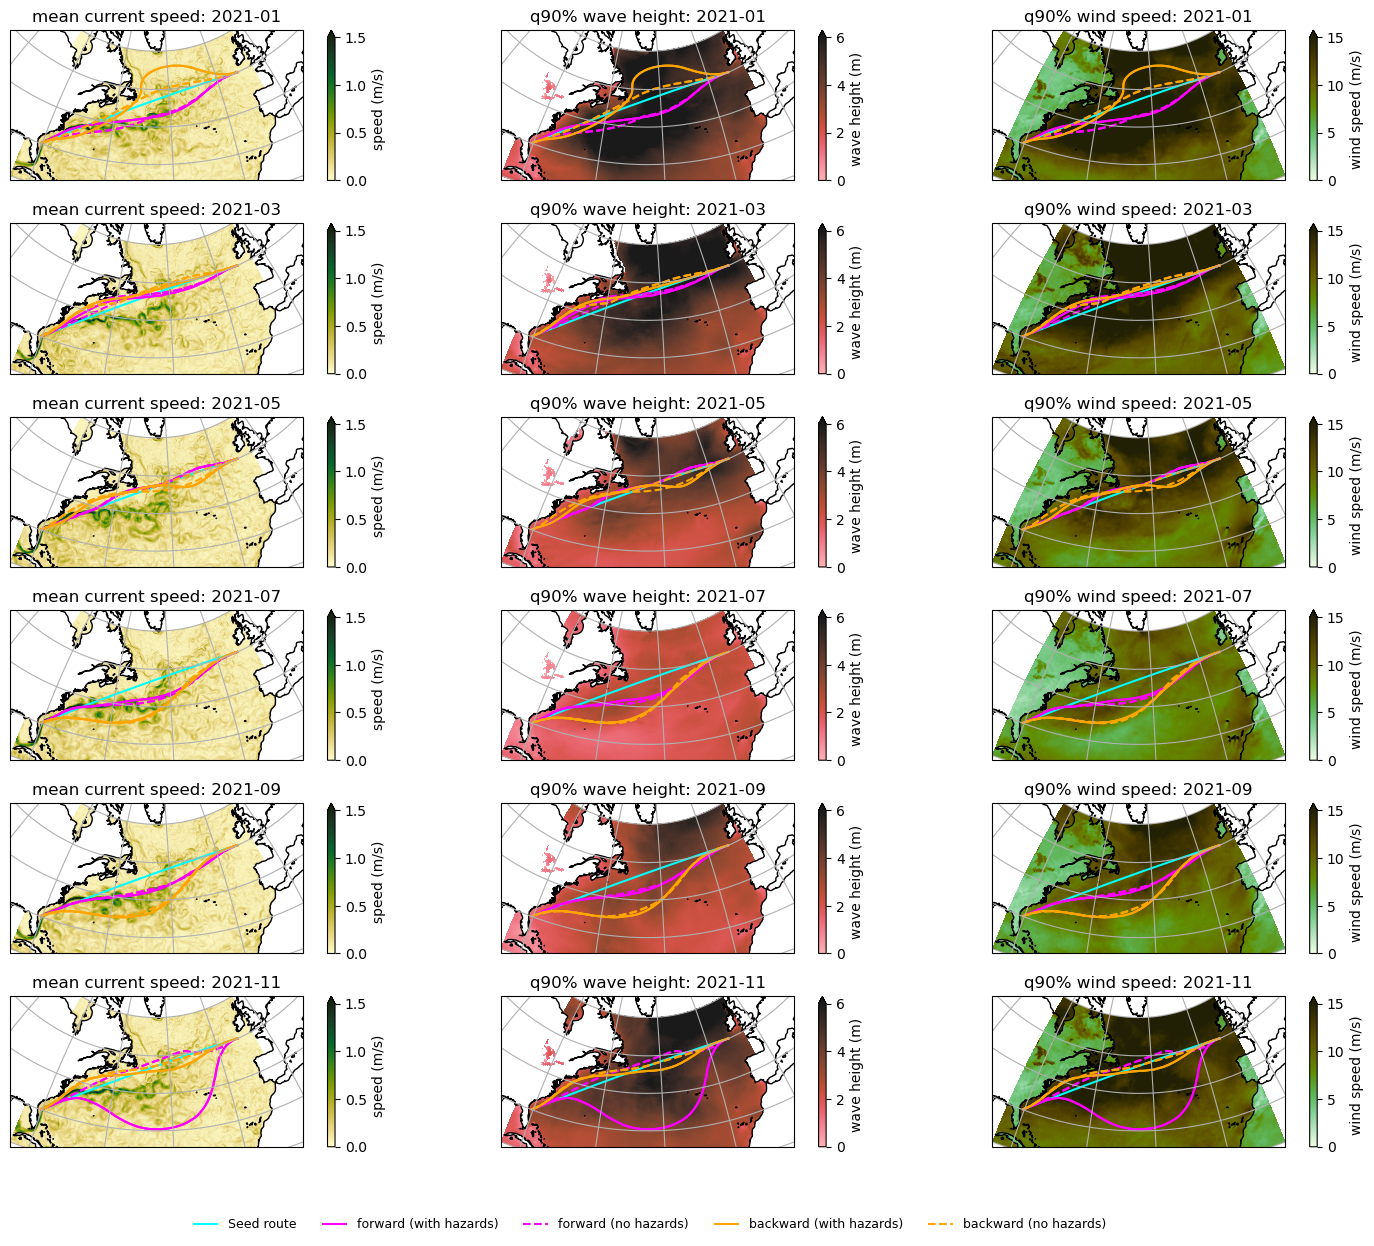

In [14]:
fig, ax = plt.subplots(
    len(times),
    3,
    subplot_kw={
        "projection": cartopy.crs.Stereographic(
            central_latitude=lat_cent, central_longitude=lon_cent
        )
    },
    figsize=(len(times) * 2.5, 3 * 4),
    sharex=True,
    sharey=True,
)

for n in range(len(times)):
    _time = times[n]
    # Filter elite routes for this time period
    time_elites = best_elites_gdf[best_elites_gdf.time_month == _time]

    for m in range(3):
        _ax = ax[n, m]

        # Plot seed route (reference route)
        gdf_seed.iloc[:1].plot(
            ax=_ax,
            transform=cartopy.crs.PlateCarree(),
            color=SEED_COLOR,
            linewidth=SEED_LINEWIDTH,
            alpha=SEED_ALPHA,
            label="Seed route",
        )

        # Plot elite routes for all configurations
        for journey_name in ["Atlantic_forward", "Atlantic_backward"]:
            for ignore_hazards in [False, True]:
                # Filter for this specific configuration
                config_routes = time_elites[
                    (time_elites.journey_name == journey_name)
                    & (time_elites.hyper_ignore_hazards == ignore_hazards)
                ]

                # Plot if routes exist for this configuration
                if len(config_routes) > 0:
                    hazard_label = "no hazards" if ignore_hazards else "with hazards"
                    direction_label = journey_name.split("_")[1]
                    style = get_route_style(journey_name, ignore_hazards)
                    config_routes.plot(
                        ax=_ax,
                        transform=cartopy.crs.PlateCarree(),
                        label=f"{direction_label} ({hazard_label})",
                        **style,
                    )

        # Plot forcing data
        if m == 0:
            ds_currents.speed.sel(time=_time).plot(
                ax=_ax,
                transform=cartopy.crs.PlateCarree(),
                vmin=0,
                vmax=1.5,
                extend="max",
                cmap=cmocean.cm.speed,
                cbar_kwargs={"label": "speed (m/s)"},
                rasterized=True,
            )
            _title = f"mean current speed: {_time}"
        if m == 1:
            ds_waves.VHM0.sel(time=_time).plot(
                ax=_ax,
                transform=cartopy.crs.PlateCarree(),
                vmin=0,
                vmax=6.0,
                extend="max",
                cmap=cmocean.cm.amp_i_r,
                cbar_kwargs={"label": "wave height (m)"},
                rasterized=True,
            )
            _title = f"q90% wave height: {_time}"
        if m == 2:
            ds_winds.speed.sel(time=_time).plot(
                ax=_ax,
                transform=cartopy.crs.PlateCarree(),
                vmin=0,
                vmax=15.0,
                extend="max",
                cmap=cmocean.cm.speed_i_r,
                cbar_kwargs={"label": "wind speed (m/s)"},
                rasterized=True,
            )
            _title = f"q90% wind speed: {_time}"

        _ax.coastlines()
        _ax.gridlines()
        _ax.set_title(_title)
        _ax.set_extent([lon_min, lon_max, lat_min, lat_max])

fig.tight_layout()

# Adjust bottom margin to make space for legend (reduced from 0.08 to 0.04)
fig.subplots_adjust(bottom=0.04)

# Add legend to avoid clutter, remove duplicates
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=6,
    frameon=False,
    fontsize=9,
)

# Save with bbox_inches='tight' to include legend
fig.savefig(
    "figures/test_cases_journey_and_forcing_overview_with_elites.png",
    dpi=200,
    bbox_inches="tight",
)
fig.savefig(
    "figures/test_cases_journey_and_forcing_overview_with_elites.pdf",
    dpi=200,
    bbox_inches="tight",
)

In [23]:
import seaborn as sns

In [63]:
best_elites_gdf = best_elites_gdf.assign(
    journey_name_short=best_elites_gdf["journey_name"].apply(lambda s: s.split("_")[-1])
)
best_elites_gdf = best_elites_gdf.assign(
    hazards_included=~best_elites_gdf.hyper_ignore_hazards
)
best_elites_gdf.hazards_included

0      True
1      True
2     False
3     False
4      True
5      True
6     False
7     False
8      True
9      True
10    False
11    False
12     True
13     True
14    False
15    False
16     True
17     True
18    False
19    False
20     True
21     True
22    False
23    False
24     True
25     True
26    False
27    False
28     True
29     True
30    False
31    False
32     True
33     True
34    False
35    False
36     True
37     True
38    False
39    False
40     True
41     True
42    False
43    False
44     True
45     True
46    False
47    False
Name: hazards_included, dtype: bool

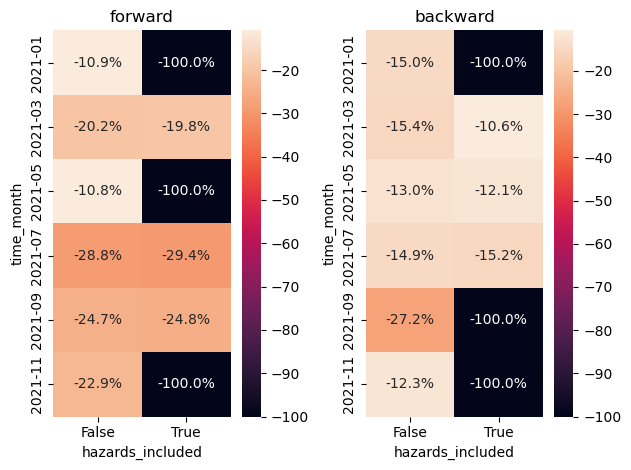

In [70]:
fig, ax = plt.subplots(1, 2)

sns.heatmap(
    (
        -100
        + 100
        * best_elites_gdf.groupby(
            ["journey_name_short", "time_month", "hazards_included"]
        )
        .elite_cost_relative.first()
        .loc["forward"]
        .unstack(-1)
    ).astype(float),
    annot=True,
    fmt=".1f",
    ax=ax[0],
    # colorbar=False
)
for t in ax[0].texts:
    t.set_text(t.get_text() + "%")

sns.heatmap(
    (
        -100
        + 100
        * best_elites_gdf.groupby(
            ["journey_name_short", "time_month", "hazards_included"]
        )
        .elite_cost_relative.first()
        .loc["backward"]
        .unstack(-1)
    ).astype(float),
    annot=True,
    fmt=".1f",
    ax=ax[1],
    # colorbar=False
)
for t in ax[1].texts:
    t.set_text(t.get_text() + "%")

ax[0].set_title("forward")
ax[1].set_title("backward")

fig.tight_layout()

fig.savefig(
    "figures/test_cases_best_cost_reduction_per_overview_case.png",
    dpi=200,
    bbox_inches="tight",
)
fig.savefig(
    "figures/test_cases_best_cost_reduction_per_overview_case.pdf",
    dpi=200,
    bbox_inches="tight",
)

In [73]:
# Get both forward and backward
both_tables = (
    (
        -100
        + 100
        * best_elites_gdf.groupby(
            ["journey_name_short", "time_month", "hazards_included"]
        )
        .elite_cost_relative.first()
        .unstack(0)
        .unstack(-1)
    )
    .astype(float)
    .round(1)
)

# Flatten multi-level columns: (direction, hazards_included)
both_tables.columns = [
    f"{direction}_{hazard}" for direction, hazard in both_tables.columns
]

print(both_tables.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & backward_False & backward_True & forward_False & forward_True \\
time_month &  &  &  &  \\
\midrule
2021-01 & -15.000000 & -100.000000 & -10.900000 & -100.000000 \\
2021-03 & -15.400000 & -10.600000 & -20.200000 & -19.800000 \\
2021-05 & -13.000000 & -12.100000 & -10.800000 & -100.000000 \\
2021-07 & -14.900000 & -15.200000 & -28.800000 & -29.400000 \\
2021-09 & -27.200000 & -100.000000 & -24.700000 & -24.800000 \\
2021-11 & -12.300000 & -100.000000 & -22.900000 & -100.000000 \\
\bottomrule
\end{tabular}



In [86]:
# Get both forward and backward
both_tables = (
    (
        best_elites_gdf.groupby(
            ["journey_name_short", "time_month", "hazards_included"]
        )
        .elite_cost_absolute.first()
        .unstack(0)
        .unstack(-1)
    )
    .astype(float)
    .round(2)
)

# Flatten multi-level columns: (direction, hazards_included)
both_tables.columns = [
    f"{direction}_{hazard}" for direction, hazard in both_tables.columns
]

print(both_tables.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & backward_False & backward_True & forward_False & forward_True \\
time_month &  &  &  &  \\
\midrule
2021-01 & 6148006149470.889648 & 6431162073454.719727 & 8500378552215.700195 & 8826261225153.640625 \\
2021-03 & 4721455509915.339844 & 4987089840095.599609 & 4149524814010.609863 & 4171074397413.500000 \\
2021-05 & 4127902653013.609863 & 4173365752681.209961 & 4495497218757.019531 & 4449965360271.110352 \\
2021-07 & 3010561880955.569824 & 3000548609108.330078 & 2296812718430.189941 & 2278663034487.609863 \\
2021-09 & 3525087470906.410156 & 3548237747044.100098 & 3140094460055.709961 & 3134071184362.439941 \\
2021-11 & 5372688480392.009766 & 5583214792946.849609 & 7012542034735.919922 & 7871838071281.299805 \\
\bottomrule
\end{tabular}



In [87]:
# Get both forward and backward
both_tables = (
    (
        best_elites_gdf.groupby(
            ["journey_name_short", "time_month", "hazards_included"]
        )
        .elite_cost_absolute.first()
        .unstack(0)
        .unstack(-1)
        / 1e12
    )
    .astype(float)
    .round(2)
)

# Flatten multi-level columns: (direction, hazards_included)
both_tables.columns = [
    f"{direction}_{hazard}" for direction, hazard in both_tables.columns
]

print(both_tables.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & backward_False & backward_True & forward_False & forward_True \\
time_month &  &  &  &  \\
\midrule
2021-01 & 6.150000 & 6.430000 & 8.500000 & 8.830000 \\
2021-03 & 4.720000 & 4.990000 & 4.150000 & 4.170000 \\
2021-05 & 4.130000 & 4.170000 & 4.500000 & 4.450000 \\
2021-07 & 3.010000 & 3.000000 & 2.300000 & 2.280000 \\
2021-09 & 3.530000 & 3.550000 & 3.140000 & 3.130000 \\
2021-11 & 5.370000 & 5.580000 & 7.010000 & 7.870000 \\
\bottomrule
\end{tabular}



<Axes: ylabel='Frequency'>

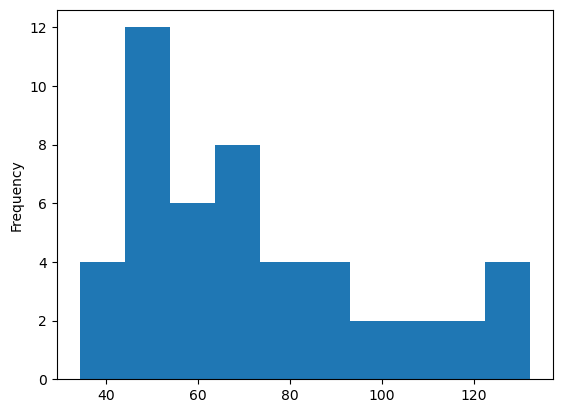

In [83]:
(0.2 * best_elites_gdf.elite_cost_absolute / 42e9 * 3.15).plot.hist()